In [1]:
import numpy as np
import time

from romgw.config.constants import PROJECT_ROOT, MODE_VALUES
from romgw.config.types import BBHSpinType, DatasetType, ModeType, ModelNameType
from romgw.config.validation import validate_literal, validate_dependent_literal
from romgw.model.core import ModeROM, ROMGW
from romgw.waveform.base import FullWaveform
from romgw.waveform.dataset import FullWaveformDataset
from romgw.waveform.params import PhysicalParams

In [2]:
from romgw.plotting.core import plot_mismatch

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
bbh_spin = "NS"
dataset = "train_xl"  # to determine which set to use known waveform values from (if applicable)
mode = "2,2"
model_name = "NonLinRegV1"

In [4]:
bbh_spin = validate_literal(
    value=bbh_spin,
    literal_type=BBHSpinType,
)
dataset = validate_literal(
    value=dataset,
    literal_type=DatasetType,
)
mode = validate_dependent_literal(
    value=mode,
    literal_type=ModeType,
    parent_value=bbh_spin,
    parent_literal_type=BBHSpinType,
    dependency_map=MODE_VALUES,
)
model_name = validate_literal(
    value=model_name,
    literal_type=ModelNameType,
)

In [5]:
# ----- Initialising reduced order models -----
mode_model = ModeROM(bbh_spin, dataset, mode, model_name)
print(f"{mode_model=}")
romgw_model = ROMGW(bbh_spin, dataset, model_name)
print(f"{romgw_model=}")

mode_model=<ModeROM>(name=NonLinRegV1, bbh_spin=NS, mode=2,2)
romgw_model=<ROMGW>(name=NonLinRegV1, bbh_spin=NS, modes=[<ModeROM>(name=NonLinRegV1, bbh_spin=NS, mode=2,2)])


In [6]:
test_param_space_file = (
    PROJECT_ROOT / "data" / bbh_spin / "test" / "parameter_space.npy"
)
X_raw = np.load(test_param_space_file, allow_pickle=False)

if bbh_spin == "NS":
    X_arr = X_raw[:, :1]
else:
    X_arr = X_raw[:, :]

if bbh_spin == "NS":
    params_list = [PhysicalParams(*arr, 0.0, 0.0) for arr in X_arr]
elif bbh_spin == "AS":
    params_list = [PhysicalParams(*arr) for arr in X_arr]
else:  # if bbh_spin == "PS"
    params_list = [PhysicalParams(arr[0], arr[1:4], arr[4:7]) for arr in X_arr]
    
M = len(params_list)

In [ ]:
# # ----- Individual waveform mode generation -----
# waveforms = [] ; i = 0 ; t_elapsed = 0
# for i in range(M):
#     print(f"Generating waveform "
#           f"{i+1:0{len(str(len(X_arr) - 1))}d}/{len(X_arr)}",
#           end='\r')
    
#     params_arr, params = X_arr[i], params_list[i]

#     t_start = time.perf_counter()
#     # ----- Time this -----
#     wf_arr = mode_model.generate_mode(params_arr)
#     # ---------------------
#     t_finish = time.perf_counter()
#     t_i = t_finish - t_start
#     t_elapsed += t_i
    
#     wf = FullWaveform(wf_arr, params)
#     waveforms.append(wf)

# print(f"Took {t_elapsed:.6f}s to generate {M} ROMGW {mode} waveform modes\n"
#       f">>> {1e3 * t_elapsed / M:.6f}ms per waveform (mean)")

# romgw_waveforms = FullWaveformDataset(waveforms)
# print(f"{romgw_waveforms=}")

Took 39.050083s to generate 256 ROMGW 2,2 waveform modes
>>> 152.539386ms per waveform (mean)
romgw_waveforms=<FullWaveformDataset(n=256, L=1)>


In [8]:
# ----- Vectorised waveform mode generation -----
t_start = time.perf_counter()
# ----- Time this -----
# waveforms_arr = mode_model.generate_mode_vectorised(X_arr)
waveforms_arr = mode_model.generate_mode(X_arr)
# ---------------------
t_finish = time.perf_counter()
t_elapsed = t_finish - t_start

print(f"Took {t_elapsed:.6f}s to generate {M} ROMGW {mode} waveform modes\n"
      f">>> {1e3 * t_elapsed / M:.6f}ms per waveform (mean)")

waveforms = [FullWaveform(waveforms_arr[i], params_list[i]) for i in range(M)]
romgw_waveforms = FullWaveformDataset(waveforms)
print(f"{romgw_waveforms=}")

Took 0.484983s to generate 256 ROMGW 2,2 waveform modes
>>> 1.894466ms per waveform (mean)
romgw_waveforms=<FullWaveformDataset(n=256, L=5251)>


In [9]:
# # ----- Individual waveform generation -----
# modes_list = [] ; i = 0 ; t_elapsed = 0
# for i in range(M):
#     print(f"Generating modes "
#           f"{i+1:0{len(str(len(X_arr) - 1))}d}/{len(X_arr)}",
#           end='\r')
    
#     params_arr, params = X_arr[i], params_list[i]

#     t_start = time.perf_counter()
#     # ----- Time this -----
#     modes_arrays = romgw_model.generate_modes(params_arr)
#     # ---------------------
#     t_finish = time.perf_counter()
#     t_i = t_finish - t_start
#     t_elapsed += t_i
    
#     modes = {m: FullWaveform(wf_arr, params)
#              for m, wf_arr in modes_arrays.items()}
#     modes_list.append(modes)

# print(f"Took {t_elapsed:.6f}s to generate {M} "
#       f"complete ROMGW waveform mode sets "
#       f"({list(romgw_model.mode_models.keys())})\n"
#       f">>> {1e3 * t_elapsed / M:.6f}ms per complete waveform mode set (mean)")

In [10]:
# # ----- Vectorised waveform generation -----
# t_start = time.perf_counter()
# # ----- Time this -----
# # modes_list = romgw_model.generate_modes_vectorised(X_arr)
# modes_list = romgw_model.generate_modes(X_arr)
# # ---------------------
# t_finish = time.perf_counter()
# t_elapsed = t_finish - t_start

# print(f"Took {t_elapsed:.6f}s to generate {M} "
#       f"complete ROMGW waveform mode sets "
#       f"({list(romgw_model.mode_models.keys())})\n"
#       f">>> {1e3 * t_elapsed / M:.6f}ms per complete waveform mode set (mean)")

In [11]:
fiducial_wf_dir = PROJECT_ROOT / "data" / bbh_spin / "test" / mode / "full" / "raw"
fiducial_waveforms = FullWaveformDataset.from_directory(fiducial_wf_dir)

Waveforms loaded.                                                               


In [12]:
# Test reconstruction maths using known waveform values at the ETNs
ei_dir_amp = (
    PROJECT_ROOT / "data" / bbh_spin / dataset / mode / "amplitude"
    / "empirical_interpolation"
)
ei_dir_phi = (
    PROJECT_ROOT / "data" / bbh_spin / dataset / mode / "phase"
    / "empirical_interpolation"
)

B_amp = np.load(ei_dir_amp / "B_matrix.npy")
B_phi = np.load(ei_dir_phi / "B_matrix.npy")
etns_amp = np.load(ei_dir_amp / "empirical_time_nodes.npy")
etns_phi = np.load(ei_dir_phi / "empirical_time_nodes.npy")

amp_arr = np.vstack([wf.amplitude for wf in fiducial_waveforms])
phi_arr = np.vstack([wf.phase for wf in fiducial_waveforms])
amp_nodes = amp_arr[:, etns_amp]
phi_nodes = phi_arr[:, etns_phi]

# empirical_interpolants_arr = mode_model.empirical_interpolant(amp_nodes, phi_nodes)
empirical_interpolants_arr = (B_amp @ amp_nodes.T).T * np.exp(-1j * (B_phi @ phi_nodes.T).T)
empirical_interpolants = FullWaveformDataset([
    FullWaveform(empirical_interpolants_arr[i], params_list[i]) for i in range(M)
])

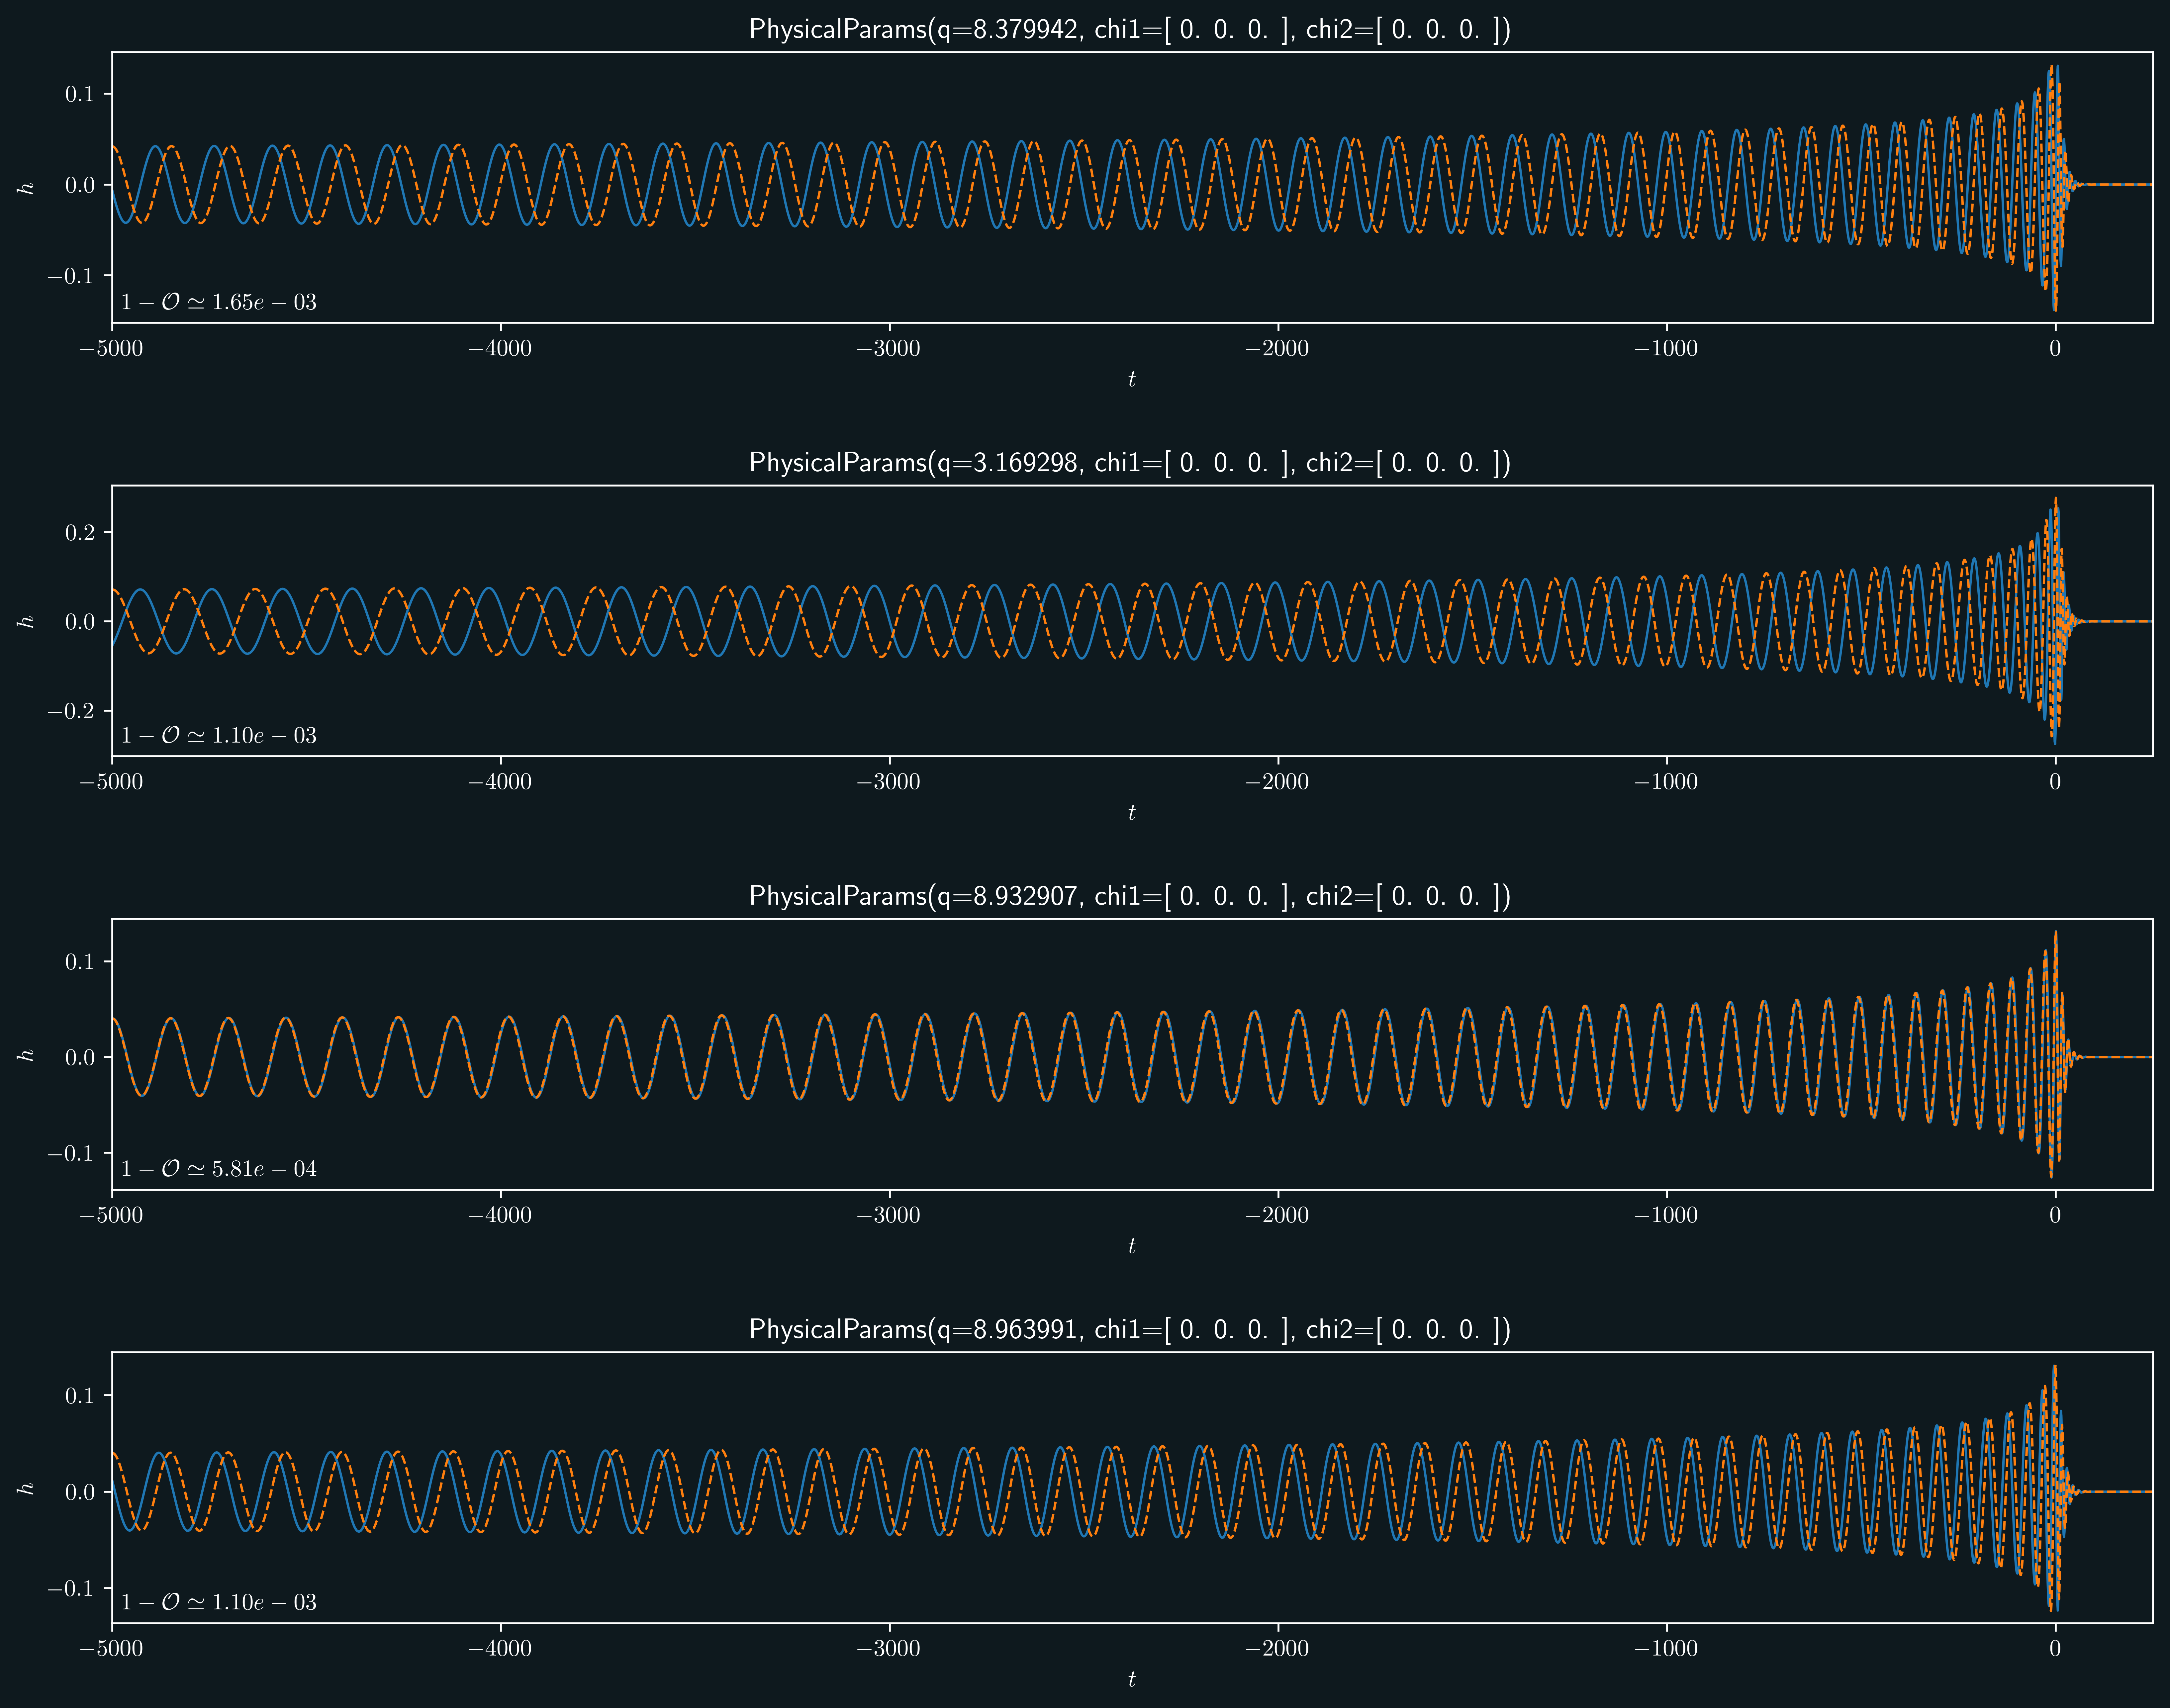

In [16]:
n_plot = 4
random_idxs = np.random.default_rng().permutation(M)[:n_plot]

plot_mismatch(
    FullWaveformDataset([fiducial_waveforms[i] for i in random_idxs]),
    FullWaveformDataset([romgw_waveforms[i] for i in random_idxs]),
    # FullWaveformDataset([empirical_interpolants[i] for i in random_idxs]),
    # component="amplitude"
)